In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rcParams.update({'font.size': 18})


Here we are assuming solutions of the form,

$$\Psi(x,y,t) = \Re\Big\{ G(y) \,e^{i k x}\, e^{-2i\omega\Omega t}\Big\}$$

(i.e. our solution is fully separable, thus a 1-dimensional problem) to the Topographic Rossby Wave Equation for linear barotropic CSWs. This means the problem we are solving is,

$$\partial_{yy} G + H\Big[\partial_y\big(\frac{1}{H}\big)-\frac{i}{\omega}\partial_x\big(\frac{1}{H}\big)\Big]\partial_y G + \Big[ikH\partial_x\big(\frac{1}{H}\big)-\frac{kH}{\omega} \partial_y\big(\frac{1}{H}\big)-k^2\Big]G = 0.$$

In the analytical problem we obtain 4 BCs by imposing matching conditions both at $y=0$ (interior of domain) and $y=\pm W$ (boundaries) but I think in the numberical procedure only the latter will be necessary as the former will be given by the spectral form of the solution. Thus the boundary conditions are,

$$\partial_y G +|k|G = 0, \;\;\text{at} \; y=W$$

$$\partial_y G -|k|G = 0, \;\;\text{at} \; y=-W.$$

This should be relative straightforward in `Cartesian` Coordinates with a `Chebyshev` basis. I with use second order tau terms and the bathymetry from the analytical problem,
$$H(y)=e^{2b(|y|-W)}.$$

In such a problem we drop the $x$ derivatives so the system is,

$$\partial_{yy} G + H\Big[\partial_y\big(\frac{1}{H}\big)\Big]\partial_y G - \Big[\frac{kH}{\omega} \partial_y\big(\frac{1}{H}\big)+k^2\Big]G = 0.$$


In [3]:
# Parameters
b = 0.5;
k = 1;
W = 1;
Ly = 1;
Ny = 200;

# Basis
coord = d3.Coordinate('y')
dist = d3.Distributor(coord, dtype=np.complex128)
basis = d3.Chebyshev(coord, Ny, bounds=(-Ly,Ly))
# Fields
G = dist.Field(name='G',bases=basis)
ωinv = dist.Field(name='ωinv')
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
namespace=locals()

# Substitutions
y = dist.local_grid(basis)
dy = lambda A: d3.Differentiate(A, coord)
lift_basis = basis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)
bathy = np.exp(2*b*(np.abs(y)-W))
bathy[y<-W] = 1;bathy[y>W] = 1;
H = dist.Field(bases=basis); H['g'] = bathy
Hinv = H**(-1)
grad_Hinv = dy(Hinv)

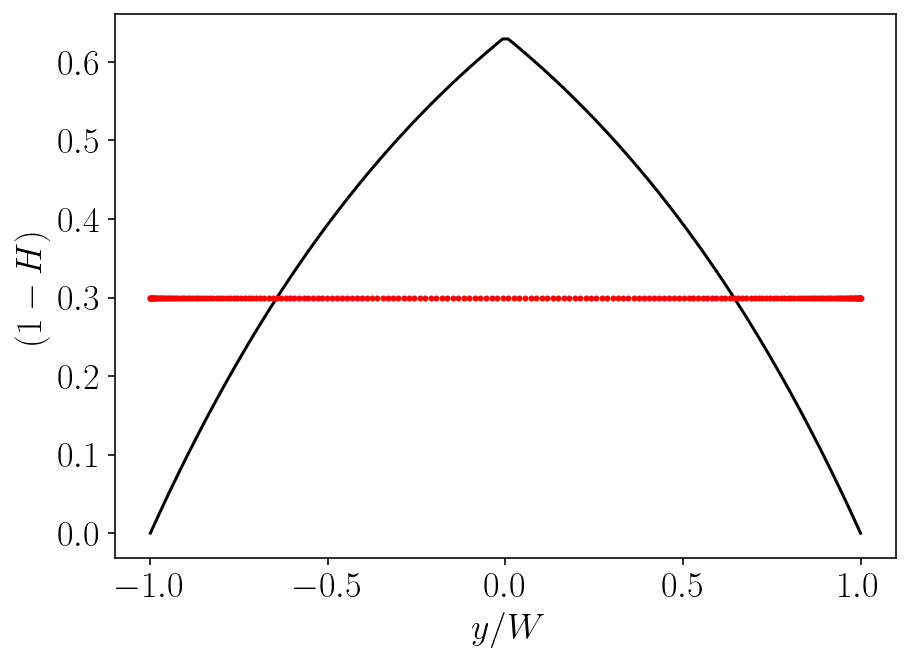

In [4]:
fig,ax = plt.subplots(1,1, figsize=(7,5)) 
ax.plot(y, 1-H['g'].real, 'k')
ax.plot(y, np.ones(Ny)*0.3, 'ro', markersize=2)
ax.set_xlabel('$y/W$')
ax.set_ylabel('$(1-H)$')
plt.show()

In [35]:
# Problem
problem = d3.EVP([G, tau_1, tau_2], eigenvalue=ωinv, namespace=namespace) 
problem.add_equation("dy(dy(G)) + (H*grad_Hinv)*dy(G) - (k*H*ωinv*grad_Hinv + k**2)*G + lift(tau_1,-1) + lift(tau_2,-2) = 0")
problem.add_equation("dy(G)(y=W)+np.abs(k)*G(y=W)=0")
problem.add_equation("dy(G)(y=-W)-np.abs(k)*G(y=-W)=0")
# Solve
solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0])

2022-08-15 15:07:40,608 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 30s, Remaining: 0s, Rate: 3.3e-02/s


In [36]:
# Solve (sparse) MUCH FASTER!! But need to know rough value of maximum frequency, also maybe not faster to construct just to solve
solver_sparse = problem.build_solver()
solver_sparse.solve_sparse(solver_sparse.subproblems[0], 40,1/1) #works with 1 in this case, but also 0.3

2022-08-15 15:07:41,645 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s


In [7]:
1/solver_sparse.eigenvalues[solver_sparse.eigenvalues>0].real
# solver_sparse.set_state(i, solver_sparse.subproblems[0].subsystems[0])


array([2.95199740e-01, 5.34360528e-02, 1.87615788e-02, 9.29574094e-03,
       5.50336490e-03, 3.63047978e-03, 2.56912212e-03, 1.91423452e-03,
       1.47936122e-03, 1.17856252e-03, 9.59717481e-04, 7.97601540e-04,
       6.72339834e-04, 5.75290949e-04, 4.96974267e-04, 4.34401692e-04,
       3.82176688e-04, 3.39545349e-04, 3.02963643e-04, 2.72656441e-04])

In [8]:
index = np.argsort(np.abs(solver.eigenvalues))

In [9]:
positive_index = index[solver.eigenvalues[index]>0]

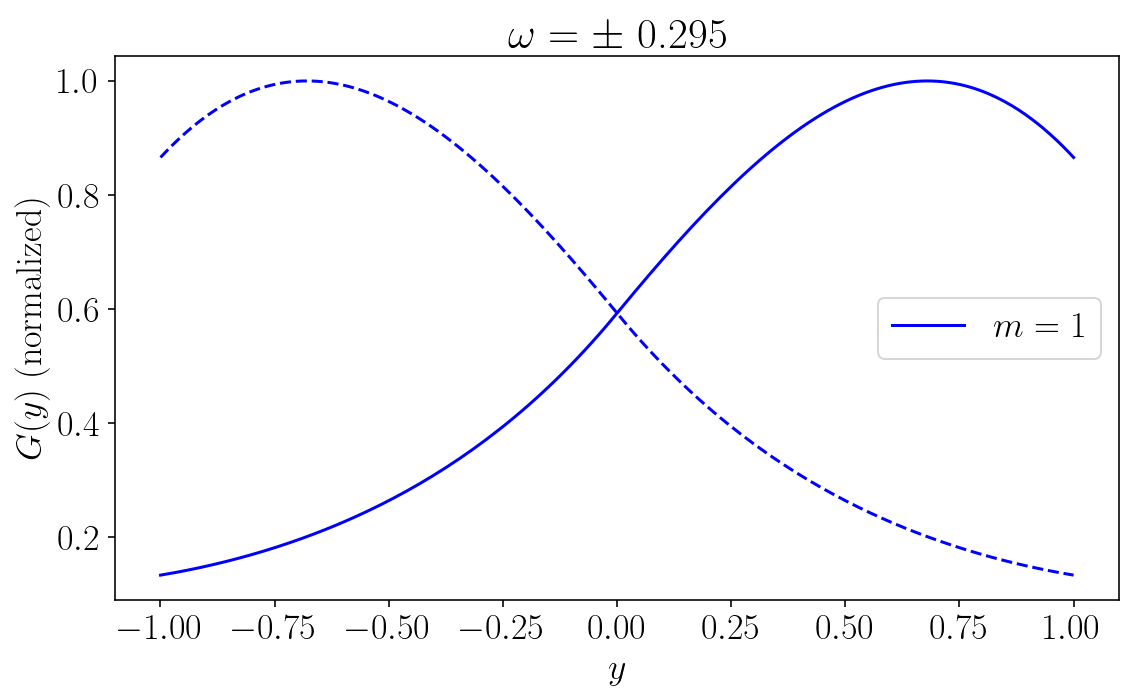

In [10]:
fig,ax = plt.subplots(1,1, figsize=(9,5)) #note this is for n=1
i = 0
if solver.eigenvalues[index[2*i]]<0:
    solver.set_state(index[2*i+1], solver.subsystems[0])
    Gg = (G['g']/G['g'].mean()).real
    ax.plot(y, Gg/np.max(np.abs(Gg)), color='b', linestyle='-',label='$m=$ '+str(i+1)+'')
    solver.set_state(index[2*i], solver.subsystems[0])
    Gg = (G['g']/G['g'].mean()).real
    ax.plot(y, Gg/np.max(np.abs(Gg)), color='b', linestyle='--')
else:
    solver.set_state(index[2*i], solver.subsystems[0])
    Gg = (G['g']/G['g'].mean()).real
    ax.plot(y, Gg/np.max(np.abs(Gg)), color='b', linestyle='-',label='$m=$ '+str(i+1)+'')
    solver.set_state(index[2*i+1], solver.subsystems[0])
    Gg = (G['g']/G['g'].mean()).real
    ax.plot(y, Gg/np.max(np.abs(Gg)), color='b', linestyle='--')
ax.set_title(r'$\omega=\pm$ %4.3f'%(1/np.abs(solver.eigenvalues[index[2*i]])))
ax.legend(loc=0)
ax.set_ylabel('$G(y)$ (normalized)'); ax.set_xlabel('$y$')
plt.show()

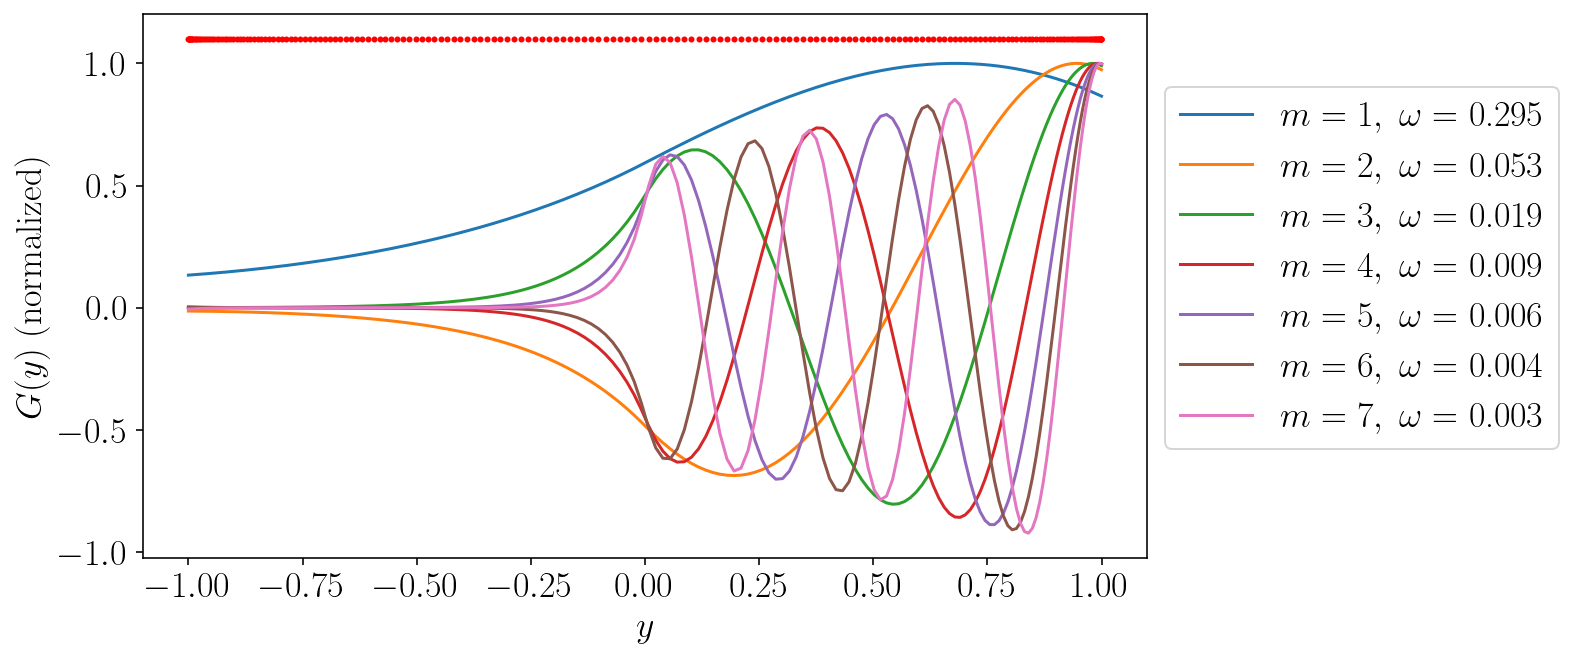

In [11]:
fig,ax = plt.subplots(1,1, figsize=(9,5)) #note this is for n=1
for i in range(7):
    solver.set_state(positive_index[i], solver.subsystems[0])
    Gg = (G['g']/G['g'].mean()).real
    ax.plot(y, Gg/np.max(np.abs(Gg)), label='$m=$ '+str(i+1)+'$,\;\omega=$ %4.3f'%(1/np.abs(solver.eigenvalues[positive_index[i]])))
ax.plot(y, np.ones(Ny)*1.1, 'ro', markersize=2)


# ax.set_title(r'$\omega=\pm$ %4.3f'%(1/np.abs(solver.eigenvalues[index[2*i]])))
# ax.legend(loc=3)
ax.legend(bbox_to_anchor=(1, 0.7, 0.3, 0.2))

ax.set_ylabel('$G(y)$ (normalized)'); ax.set_xlabel('$y$')
plt.show()

So these frequencies are a little off from what I have in the MATLAB script, potentially an error in my 'analytical' root finding method because these look good and converged.

## Dispersion relation (chebyshev)

In [12]:
# Parameters
b = 0.5;
# k_list = np.linspace(1,50,100); # for some reason this didn't work
k=1;
W = 1;
Ly = 1;
Ny = 200;

In [13]:
# Basis
coord = d3.Coordinate('y')
dist = d3.Distributor(coord, dtype=np.complex128)
basis = d3.Chebyshev(coord, Ny, bounds=(-Ly,Ly))
# Fields
G = dist.Field(name='G',bases=basis)
ωinv = dist.Field(name='ωinv')
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
namespace=locals()
# Substitutions
y = dist.local_grid(basis)
dy = lambda A: d3.Differentiate(A, coord)
lift_basis = basis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)
bathy = np.exp(2*b*(np.abs(y)-W))
bathy[y<-W] = 1;bathy[y>W] = 1;
H = dist.Field(bases=basis); H['g'] = bathy
Hinv = H**(-1)
grad_Hinv = dy(Hinv)

In [14]:
def ω_roots_k(k ,fine):
    # Problem
    problem = d3.EVP([G, tau_1, tau_2], eigenvalue=ωinv, namespace=namespace) 
    if fine == True:
        problem.namespace['k'] = k/20
    else:
        problem.namespace['k'] = k/2
    problem.add_equation("dy(dy(G)) + (H*grad_Hinv)*dy(G) - (k*H*ωinv*grad_Hinv + k**2)*G + lift(tau_1,-1) + lift(tau_2,-2) = 0")
    problem.add_equation("dy(G)(y=W)+np.abs(k)*G(y=W)=0")
    problem.add_equation("dy(G)(y=-W)-np.abs(k)*G(y=-W)=0")
    # Solve (sparse) MUCH FASTER!! But need to know rough value of maximum frequency, also maybe not faster to construct just to solve
    solver_sparse = problem.build_solver()
    solver_sparse.solve_sparse(solver_sparse.subproblems[0], 50,1) 
    ω_roots = 1/solver_sparse.eigenvalues[solver_sparse.eigenvalues>0].real
    return ω_roots

evals_fine = np.array([ω_roots_k(k, True) for k in range(1,41)])
evals_course = np.array([ω_roots_k(k, False) for k in range(5,101)])


2022-08-15 14:15:14,059 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 27s, Remaining: 0s, Rate: 3.7e-02/s
2022-08-15 14:15:14,785 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s
2022-08-15 14:15:15,794 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.1e+00/s
2022-08-15 14:15:16,496 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s
2022-08-15 14:15:17,241 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s
2022-08-15 14:15:17,962 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s
2022-08-15 14:15:18,796 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.4e+00/s
2022-08-15 14:15:19,613 subsystems 0/1 INFO :: Building subproblem matrices

In [15]:
k_list = np.append(np.arange(1,41)/20, np.arange(5,101)/2)
evals_chebyshev = np.append(evals_fine,evals_course,axis=0)

In [16]:
from collections import OrderedDict

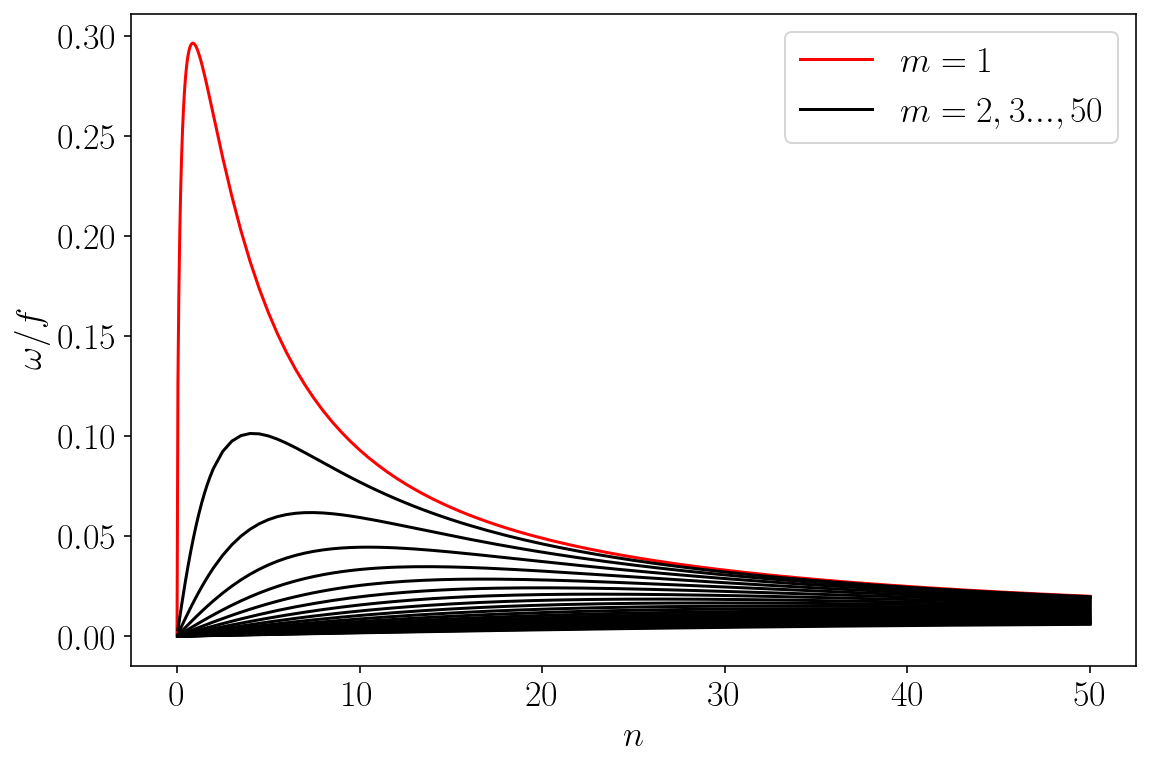

In [17]:
fig,ax = plt.subplots(1,1, figsize=(9,6)) 
ax.plot(np.append(0,k_list), np.append(0,evals_chebyshev[:,0]), 'r-', label='$m=1$')
ax.plot(k_list, evals_chebyshev[:,1:], 'k-',label='$m=2,3...,50$')
# ax.set_ylim([0,0.3]);ax.set_xlim([0,50])
ax.set_ylabel('$\omega/f$'); ax.set_xlabel('$n$'); #ax.legend(loc=1)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

### Resolution constraints (coupled problem)

If we expand the domain to a length comparable to the full annulus and make the domain periodic, what resolution do we need? Let's say that the ridge takes up 1/5th of the annulus, so $W=1$ and $Ly = 5$. 

In [288]:
# Parameters
b = 0.5;
k = 1;
W = 1;
Ly = 5; # for some reason it';s pretty sensitive to this... many values give garbage
Ny = 64; ## currently have 64 in full solver, honestly dont seem to gain much from increase

In [289]:
# Basis
coord = d3.Coordinate('y')
dist = d3.Distributor(coord, dtype=np.complex128)
basis = d3.ComplexFourier(coord, Ny, bounds=(-Ly,Ly))
# Fields
G = dist.Field(name='G',bases=basis)
ωinv = dist.Field(name='ωinv')
namespace=locals()
# Substitutions
y = dist.local_grid(basis)
dy = lambda A: d3.Differentiate(A, coord)
bathy = np.exp(2*b*(np.abs(y)-W))
bathy[y<-W] = 1;bathy[y>W] = 1;
H = dist.Field(bases=basis); H['g'] = bathy
Hinv = H**(-1)
grad_Hinv = dy(Hinv)

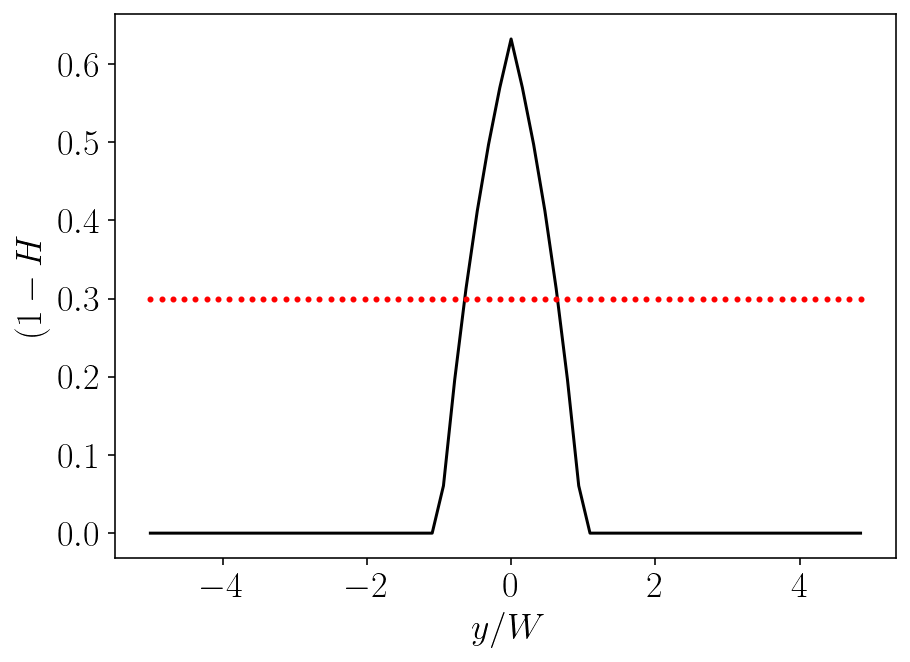

In [290]:
fig,ax = plt.subplots(1,1, figsize=(7,5)) 
ax.plot(y, 1-H['g'].real, 'k')
ax.plot(y, np.ones(Ny)*0.3, 'ro', markersize=2)
ax.set_xlabel('$y/W$')
ax.set_ylabel('$(1-H$')
plt.show()

In [291]:
# Problem
problem = d3.EVP([G], eigenvalue=ωinv, namespace=namespace) 
problem.add_equation("dy(dy(G)) + (H*grad_Hinv)*dy(G) - (k*H*ωinv*grad_Hinv + k**2)*G = 0")
# Solve
solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0])

2022-08-16 13:59:53,274 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+00/s


In [292]:
# Solve (sparse) MUCH FASTER!! But need to know rough value of maximum frequency, also maybe not faster to construct just to solve
solver_sparse = problem.build_solver()
solver_sparse.solve_sparse(solver_sparse.subproblems[0], 10,1/0.3) #works with 1 in this case, but also 0.3
## DONT KNOW HOW TO SET STATE TO THIS THOUGH
# solver_sparse.set_state(i, solver_sparse.subproblems[0].subsystems[0])

2022-08-16 13:59:53,827 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.7e+00/s


In [293]:
index = np.argsort(np.abs(solver.eigenvalues))

In [294]:
positive_index = index[solver.eigenvalues[index]>0]

In [295]:
1/solver.eigenvalues[positive_index][:10]

array([0.29736683-4.80073187e-05j, 0.05505057-6.89320545e-06j,
       0.01954603-3.61894139e-06j, 0.00986074+8.29144810e-07j,
       0.00550535-1.37235847e-06j, 0.0034785 -1.03939014e-06j,
       0.00286835-4.76798094e-05j, 0.00247296-2.41231560e-05j,
       0.00225374+4.21183623e-05j, 0.00208172+2.82027877e-05j])

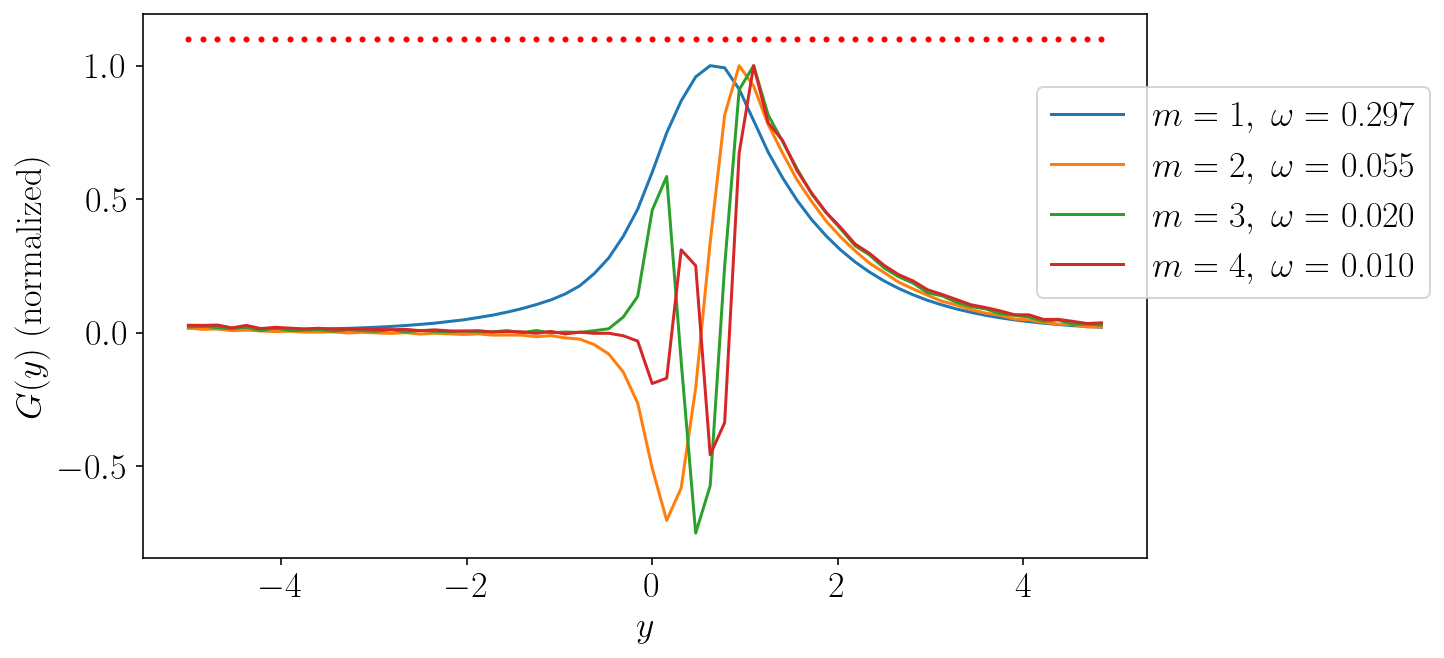

In [296]:
fig,ax = plt.subplots(1,1, figsize=(9,5)) #note this is for n=1
for i in range(4):
    solver.set_state(positive_index[i], solver.subsystems[0])
    Gg = (G['g']/G['g'].mean()).real
    ax.plot(y, Gg/np.max(np.abs(Gg)), label='$m=$ '+str(i+1)+'$,\;\omega=$ %4.3f'%(1/np.abs(solver.eigenvalues[positive_index[i]])))
ax.plot(y, np.ones(Ny)*1.1, 'ro', markersize=2)


# ax.set_title(r'$\omega=\pm$ %4.3f'%(1/np.abs(solver.eigenvalues[index[2*i]])))
# ax.legend(loc=3)""
ax.legend(bbox_to_anchor=(1, 0.7, 0.3, 0.2))

ax.set_ylabel('$G(y)$ (normalized)'); ax.set_xlabel('$y$')
plt.show()

## Dispersion relation (periodic)

In [28]:
# Parameters
b = 0.5;
k = 1;
W = 1;
Ly = 1;
Ny = 64;

In [29]:
# Basis
coord = d3.Coordinate('y')
dist = d3.Distributor(coord, dtype=np.complex128)
basis = d3.ComplexFourier(coord, Ny, bounds=(-Ly,Ly))
# Fields
G = dist.Field(name='G',bases=basis)
ωinv = dist.Field(name='ωinv')
namespace=locals()
# Substitutions
y = dist.local_grid(basis)
dy = lambda A: d3.Differentiate(A, coord)
bathy = np.exp(2*b*(np.abs(y)-W))
bathy[y<-W] = 1;bathy[y>W] = 1;
H = dist.Field(bases=basis); H['g'] = bathy
Hinv = H**(-1)
grad_Hinv = dy(Hinv)

In [30]:
def ω_roots_k(k ,fine):
    # Problem
    problem = d3.EVP([G], eigenvalue=ωinv, namespace=namespace) 
    if fine == True:
        problem.namespace['k'] = k/20
    else:
        problem.namespace['k'] = k/2
    problem.add_equation("dy(dy(G)) + (H*grad_Hinv)*dy(G) - (k*H*ωinv*grad_Hinv + k**2)*G = 0")
    # Solve (sparse) MUCH FASTER!! But need to know rough value of maximum frequency, also maybe not faster to construct just to solve
    solver_sparse = problem.build_solver()
    solver_sparse.solve_sparse(solver_sparse.subproblems[0], 50,1) 
    ω_roots = 1/solver_sparse.eigenvalues[solver_sparse.eigenvalues>0].real
    return np.flip(np.sort(ω_roots))

evals_fine = np.array([ω_roots_k(k, True) for k in range(1,41)])
evals_coarse = np.array([ω_roots_k(k, False) for k in range(5,101)])


2022-08-15 14:16:53,800 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s
2022-08-15 14:16:53,882 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.8e+01/s
2022-08-15 14:16:53,954 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2022-08-15 14:16:54,023 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+01/s
2022-08-15 14:16:54,097 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+01/s
2022-08-15 14:16:54,167 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2022-08-15 14:16:54,237 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+01/s
2022-08-15 14:16:54,322 subsystems 0/1 INFO :: Building subproblem matrices 

In [31]:
k_list = np.append(np.arange(1,41)/20, np.arange(5,101)/2)
evals_fourier = np.append(evals_fine,evals_coarse,axis=0)

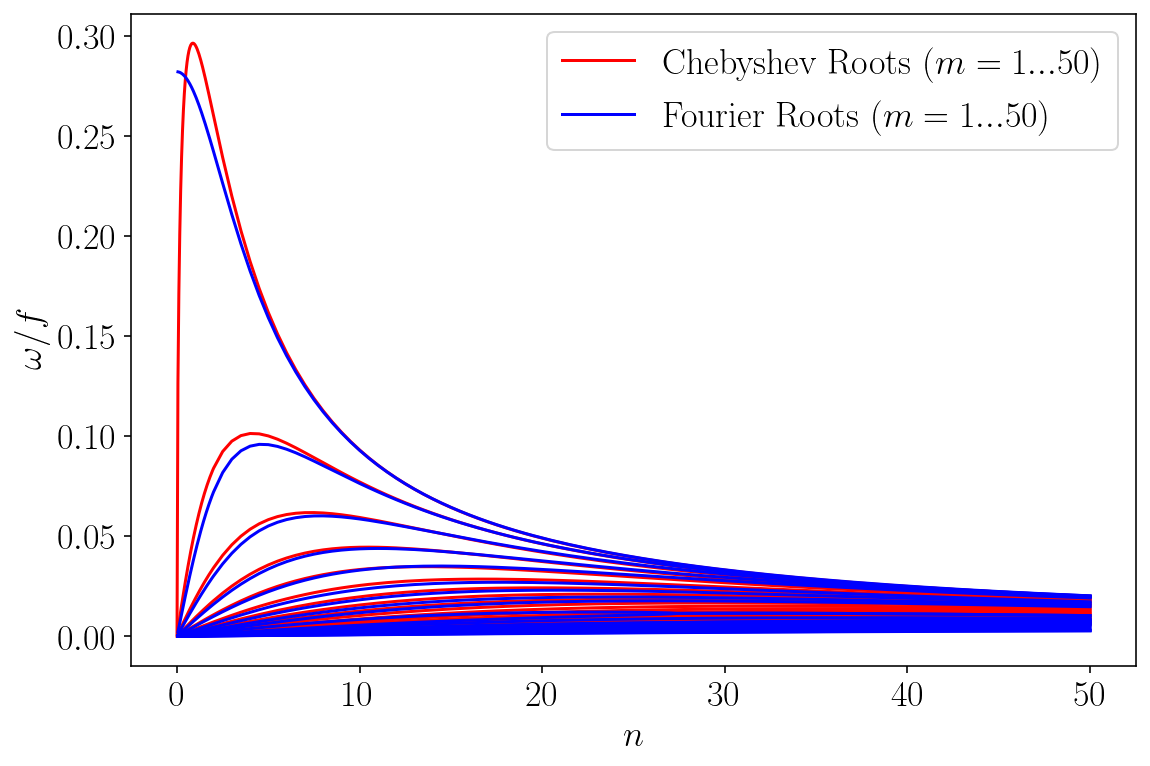

In [32]:
fig,ax = plt.subplots(1,1, figsize=(9,6)) 
ax.plot(np.append(0,k_list), np.append(0,evals_chebyshev[:,0]), 'r-', label='Chebyshev Roots $(m=1...50)$')
ax.plot(k_list, evals_chebyshev[:,1:], 'r-')
ax.plot(k_list, evals_fourier[:,0], 'b-', label='Fourier Roots $(m=1...50)$')
ax.plot(k_list, evals_fourier[:,1:], 'b-')

# ax.set_ylim([0,0.3]);ax.set_xlim([0,50])
ax.set_ylabel('$\omega/f$'); ax.set_xlabel('$n$'); #ax.legend(loc=1)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

The ridge problem doesn't work particularly well in the Fourier basis, works better in Chebyshev, but the best performance seems to be with a ridge 1/5th the angle of the domain and 64 points should be fine...

## Convert to Polar coordinate domain! (explicitly...need to change problem equations)


So when we include the ridge in our annulus domain we will be solving it as a ridge 'fan' in polar coordinates. I want to test that in isolation here.

In this case we will be assuming a radial wave ansatz,

$$\Psi(x,y,t) = \Re\Big\{ G(\theta) \,e^{i k r}\, e^{-2i\omega\Omega t}\Big\}$$

so the CSW equations in polar coordinates. In the 2D case we just have $H$ as a function of $\theta$ so our input equation will be,


$$\frac{1}{H}G''(\theta)+\frac{\partial}{\partial \theta}\Big(\frac{1}{H}\Big)G'(\theta)-\Big[r^2k^2+\frac{kr}{\omega}\frac{\partial}{\partial \theta}\Big(\frac{1}{H}\Big)-ikr\Big]G(\theta) = 0.$$

If we keep in in `Chebyshev` basis the boundary conditions will be,
$$G'(\theta) +r|k|G(\theta) = 0, \;\;\text{at} \; \theta=W$$

$$G'(\theta) -r|k|G(\theta) = 0, \;\;\text{at} \; \theta=-W.$$

Noting that $W$ will be an angle now. Not entirely sure this is the right BC but I'll try it.


We will need to define the problem in 2D because of the $r$ terms...

In [165]:
# Parameters
b = 0.5;
k = 1;
W = np.pi/2;
Lθ = np.pi/2;
Ri, Ro = 0.5, 5 
Nθ, Nr = 64, 32 #resolution

# Basis
coords = d3.CartesianCoordinates('θ', 'r')
dist = d3.Distributor(coords, dtype=np.complex128)
θbasis = d3.Chebyshev(coords['θ'], Nθ, (-Lθ, Lθ))
rbasis = d3.ComplexFourier(coords['r'], Nr, (Ri, Ro))

# Fields
G = dist.Field(name='G',bases=(θbasis, rbasis))
ωinv = dist.Field(name='ωinv')
tau_1 = dist.Field(name='tau_1', bases=rbasis)
tau_2 = dist.Field(name='tau_2', bases=rbasis)
namespace=locals()

# Substitutions
θ, r = dist.local_grids(θbasis, rbasis)
dθ = lambda A: d3.Differentiate(A, coord)
lift_basis = θbasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)

bathy = np.exp(2*b*(np.abs(θ)-W))
bathy[θ<-W] = 1;bathy[θ>W] = 1;
H = dist.Field(bases=θbasis); H['g'] = bathy
Hinv = H**(-1)
grad_Hinv = dθ(Hinv)
rfield = dist.Field(bases=rbasis); rfield['g'] = r

/var/folders/bg/tg7qc0rx1qxdpz1j_8l_xj440000gq/T/ipykernel_76381/2613551297.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax1.pcolormesh(X,Y,1-(H['g'].real*np.ones_like(R)))


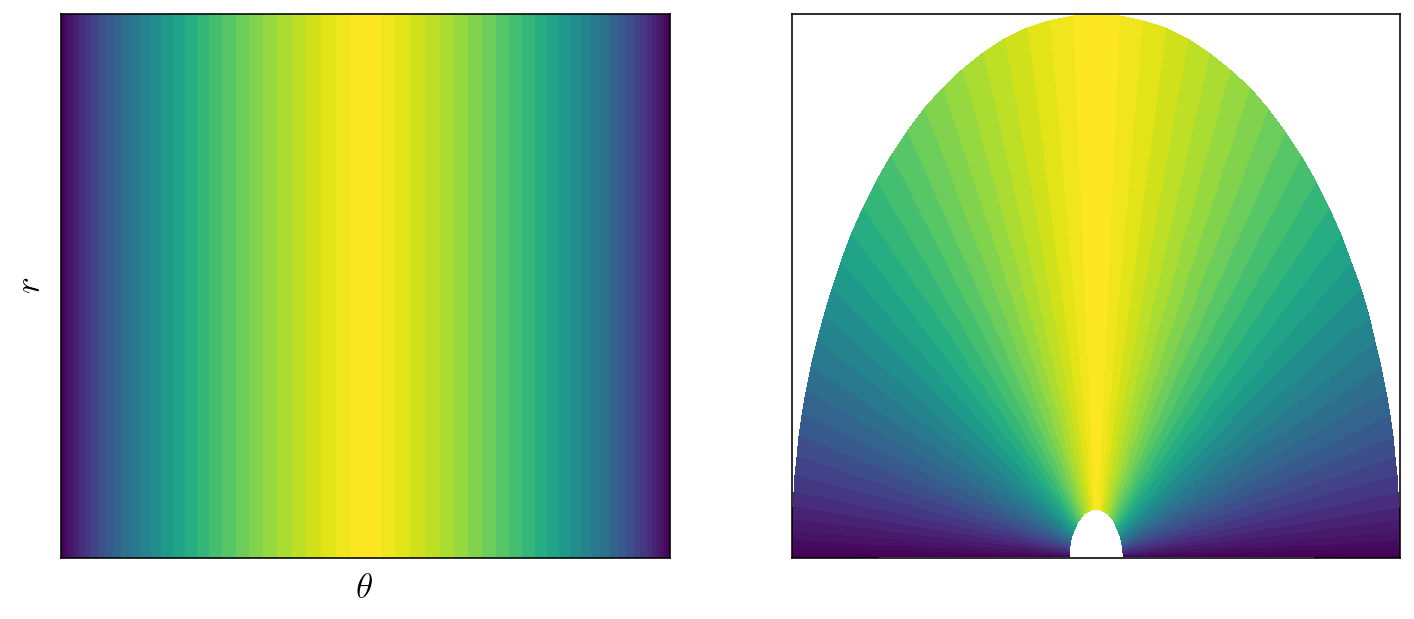

In [166]:
R,THETA = np.meshgrid(r,θ)
X = R*np.cos(THETA+np.pi/2); Y=R*np.sin(THETA+np.pi/2)

fig,(ax,ax1) = plt.subplots(1,2, figsize=(12,5)) #note this is for n=1
ax.pcolormesh(THETA,R,1-(H['g'].real*np.ones_like(R)))
ax1.pcolormesh(X,Y,1-(H['g'].real*np.ones_like(R)))
ax.set_xlabel(r'$\theta$');ax.set_ylabel('$r$')
ax.set_xticks([]);ax.set_yticks([])
ax1.set_xticks([]);ax1.set_yticks([])
plt.show()

In [171]:
# Problem
problem = d3.EVP([G, tau_1, tau_2], eigenvalue=ωinv, namespace=namespace) 
problem.add_equation("Hinv*dθ(dθ(G)) + grad_Hinv*dθ(G) - (k**2*rfield**2+k*rfield*ωinv*grad_Hinv-1j*k*rfield)*G + lift(tau_1,-1) + lift(tau_2,-2) = 0")
problem.add_equation("dθ(G)(θ=W)+rfield*np.abs(k)*G(θ=W)=0")
problem.add_equation("dθ(G)(θ=-W)-rfield*np.abs(k)*G(θ=-W)=0")
# Solve
solver_sparse = problem.build_solver()
solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0])
# solver_sparse.solve_sparse(solver_sparse.subproblems[0], 20,1/0.3) # solver sparse really helps with the timing but I struggled to find the right values (can't specify real?)

2022-08-16 09:31:44,855 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 8s, Remaining: 0s, Rate: 1.2e-01/s


In [204]:
ω_eigs_all = 1/solver.eigenvalues
## get rid of infty values
ω_eigs = ω_eigs_all[np.abs(ω_eigs_all)>0]
ω_eigs_index = np.where(np.abs(ω_eigs_all)>0)[0]
## based on plot, only keep values less than 0.3
ω_eigs_trimmed = ω_eigs[np.abs(ω_eigs)<0.30]
ω_eigs_trimmed_index = ω_eigs_index[np.where(np.abs(ω_eigs)<0.30)[0]]


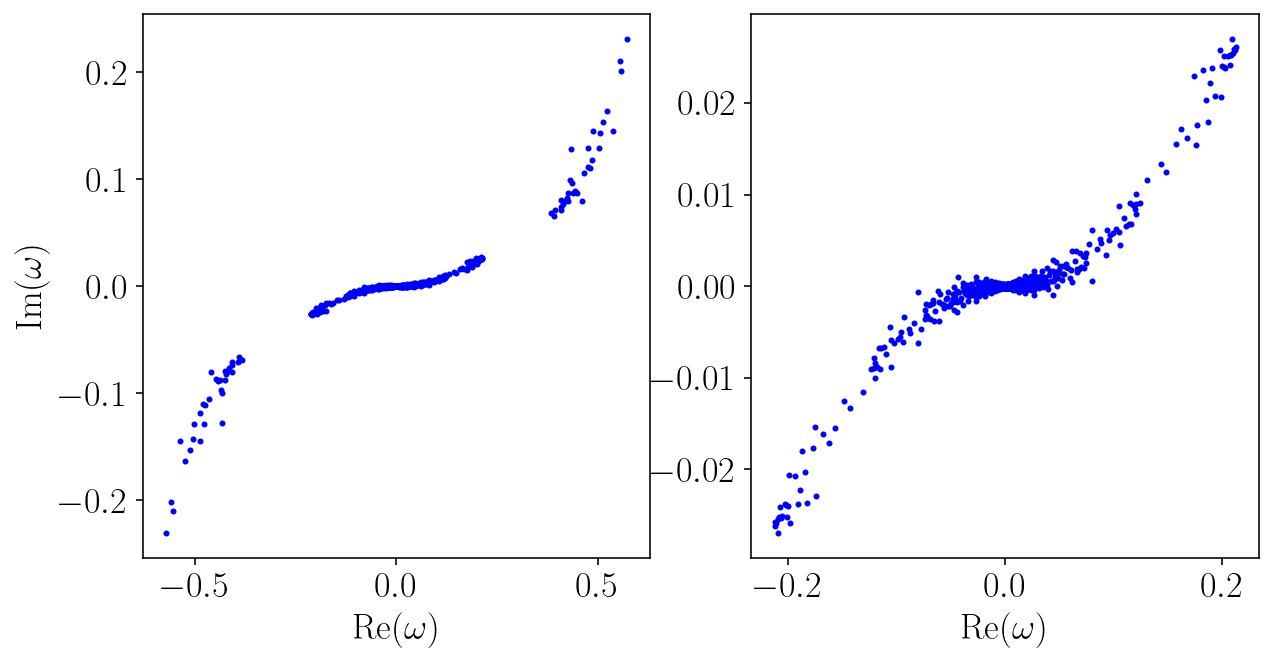

In [218]:
fig,(ax,ax1) = plt.subplots(1,2, figsize=(10,5)) 
ax.plot(ω_eigs.real, ω_eigs.imag, 'bo', markersize=2)
ax1.plot(ω_eigs_trimmed.real, ω_eigs_trimmed.imag, 'bo', markersize=2)
ax.set_ylabel(r'$\textrm{Im}(\omega)$');ax.set_xlabel(r'$\textrm{Re}(\omega)$');ax1.set_xlabel(r'$\textrm{Re}(\omega)$')
plt.show()

In [228]:
ω_eigs_sort = ω_eigs_trimmed[np.argsort(np.abs(ω_eigs_trimmed.real))]
ω_eigs_sort_index = ω_eigs_trimmed_index[np.argsort(np.abs(ω_eigs_trimmed.real))]

In [237]:
ω_eigs_sort_pos = np.flip(ω_eigs_sort[ω_eigs_sort>0])
ω_eigs_sort_pos_index = np.flip(ω_eigs_sort_index[ω_eigs_sort>0])

In [236]:
ω_eigs_sort_pos[0]

(0.21250743696286675+0.02615613798360048j)

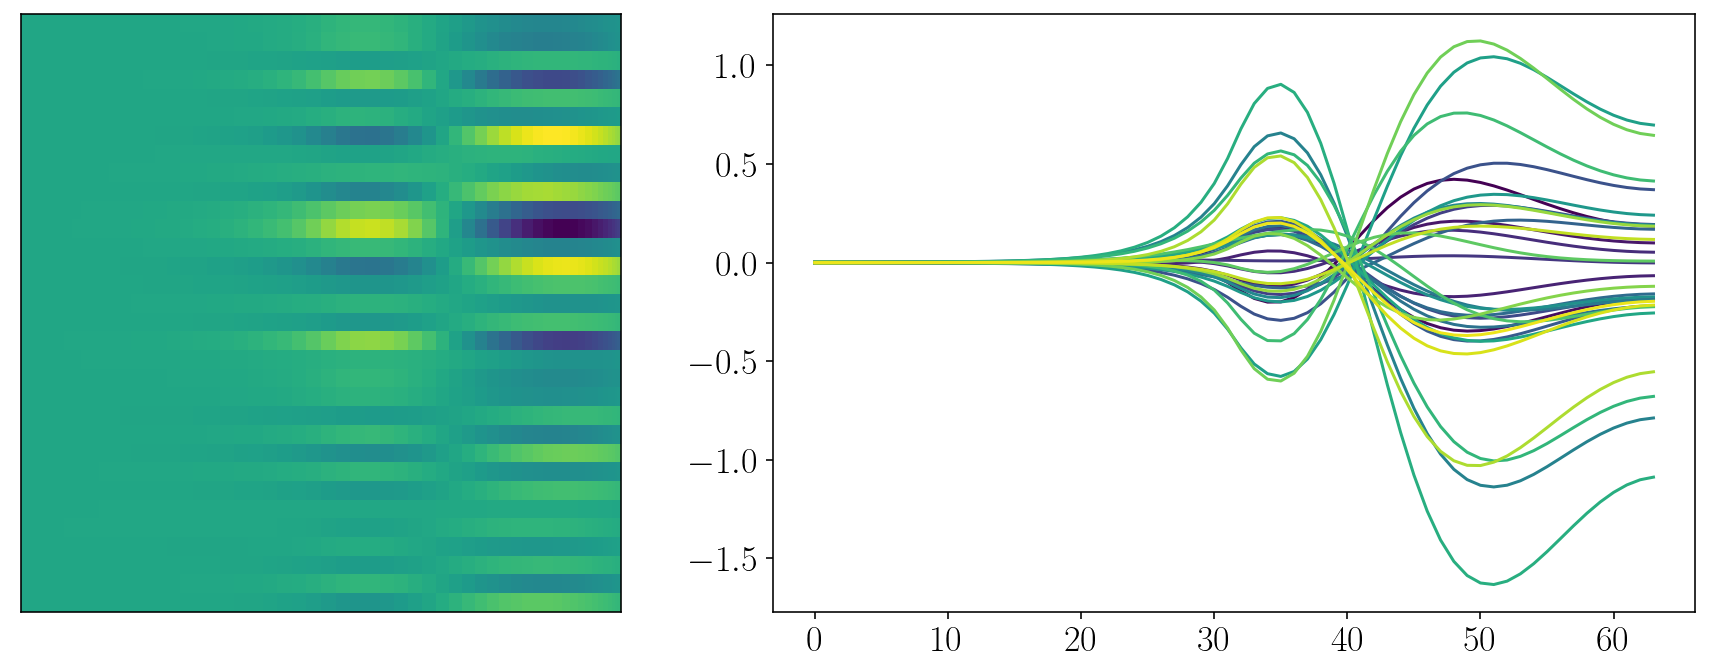

In [245]:
ωx,(ax,ax1) = plt.subplots(1,2, figsize=(15,5.5),gridspec_kw={'width_ratios': [1.3,2]})
i=3
solver.set_state(ω_eigs_sort__pos_index[i], solver.subsystems[0]) 
ax.pcolormesh(THETA,R,(G['g'].real))
cmap = mpl.cm.get_cmap('viridis')
for j in range(Nr):
    ax1.plot(np.real(G['g'])[:,j], color=cmap(j/Nr))

ax.set_xticks([]);ax.set_yticks([])
plt.show()

/var/folders/bg/tg7qc0rx1qxdpz1j_8l_xj440000gq/T/ipykernel_76381/4165378957.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(X,Y,(G['g'].real))


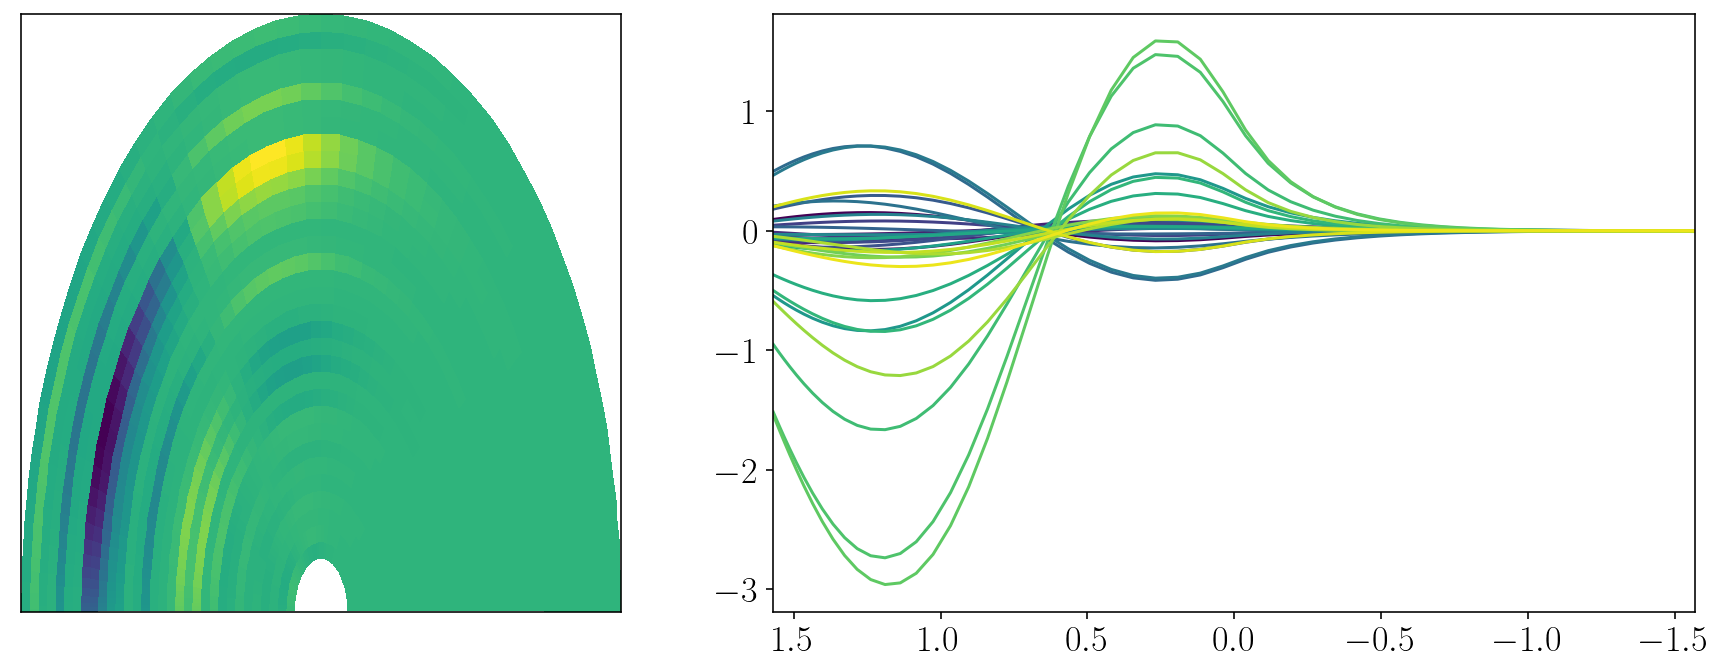

In [247]:
ωx,(ax,ax1) = plt.subplots(1,2, figsize=(15,5.5),gridspec_kw={'width_ratios': [1.3,2]})
i=1
X = R*np.cos(THETA+np.pi/2); Y=R*np.sin(THETA+np.pi/2)
solver.set_state(ω_eigs_sort__pos_index[i], solver.subsystems[0]) 
ax.pcolormesh(X,Y,(G['g'].real))
cmap = mpl.cm.get_cmap('viridis')
for j in range(Nr):
    ax1.plot(θ,np.real(G['g'])[:,j], color=cmap(j/Nr))
    ax1.set_xlim([np.pi/2,-np.pi/2])
ax.set_xticks([]);ax.set_yticks([])
plt.show()

Up the radial resolution, see how these differ

In [248]:
# Parameters
b = 0.5;
k = 1;
W = np.pi/2;
Lθ = np.pi/2;
Ri, Ro = 0.5, 5 
Nθ, Nr = 64, 64 #resolution

# Basis
coords = d3.CartesianCoordinates('θ', 'r')
dist = d3.Distributor(coords, dtype=np.complex128)
θbasis = d3.Chebyshev(coords['θ'], Nθ, (-Lθ, Lθ))
rbasis = d3.ComplexFourier(coords['r'], Nr, (Ri, Ro))

# Fields
G = dist.Field(name='G',bases=(θbasis, rbasis))
ωinv = dist.Field(name='ωinv')
tau_1 = dist.Field(name='tau_1', bases=rbasis)
tau_2 = dist.Field(name='tau_2', bases=rbasis)
namespace=locals()

# Substitutions
θ, r = dist.local_grids(θbasis, rbasis)
dθ = lambda A: d3.Differentiate(A, coord)
lift_basis = θbasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)

bathy = np.exp(2*b*(np.abs(θ)-W))
bathy[θ<-W] = 1;bathy[θ>W] = 1;
H = dist.Field(bases=θbasis); H['g'] = bathy
Hinv = H**(-1)
grad_Hinv = dθ(Hinv)
rfield = dist.Field(bases=rbasis); rfield['g'] = r

/var/folders/bg/tg7qc0rx1qxdpz1j_8l_xj440000gq/T/ipykernel_76381/2613551297.py:6: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax1.pcolormesh(X,Y,1-(H['g'].real*np.ones_like(R)))


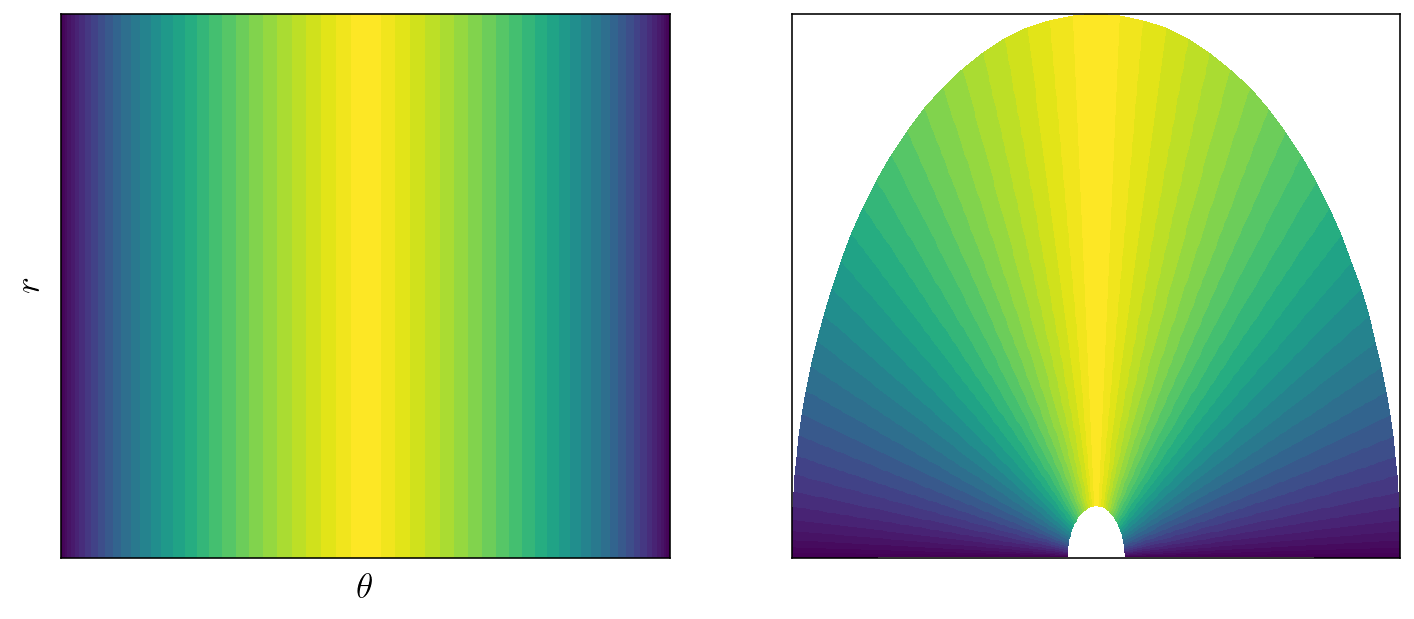

In [249]:
R,THETA = np.meshgrid(r,θ)
X = R*np.cos(THETA+np.pi/2); Y=R*np.sin(THETA+np.pi/2)

fig,(ax,ax1) = plt.subplots(1,2, figsize=(12,5)) #note this is for n=1
ax.pcolormesh(THETA,R,1-(H['g'].real*np.ones_like(R)))
ax1.pcolormesh(X,Y,1-(H['g'].real*np.ones_like(R)))
ax.set_xlabel(r'$\theta$');ax.set_ylabel('$r$')
ax.set_xticks([]);ax.set_yticks([])
ax1.set_xticks([]);ax1.set_yticks([])
plt.show()

In [250]:
# Problem
problem = d3.EVP([G, tau_1, tau_2], eigenvalue=ωinv, namespace=namespace) 
problem.add_equation("Hinv*dθ(dθ(G)) + grad_Hinv*dθ(G) - (k**2*rfield**2+k*rfield*ωinv*grad_Hinv-1j*k*rfield)*G + lift(tau_1,-1) + lift(tau_2,-2) = 0")
problem.add_equation("dθ(G)(θ=W)+rfield*np.abs(k)*G(θ=W)=0")
problem.add_equation("dθ(G)(θ=-W)-rfield*np.abs(k)*G(θ=-W)=0")
# Solve
solver_sparse = problem.build_solver()
solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0])
# solver_sparse.solve_sparse(solver_sparse.subproblems[0], 20,1/0.3) # solver sparse really helps with the timing but I struggled to find the right values (can't specify real?)

2022-08-16 10:08:07,354 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1m 35s, Remaining: 0s, Rate: 1.1e-02/s


In [251]:
ω_eigs_all = 1/solver.eigenvalues
## get rid of infty values
ω_eigs = ω_eigs_all[np.abs(ω_eigs_all)>0]
ω_eigs_index = np.where(np.abs(ω_eigs_all)>0)[0]
## based on plot, only keep values less than 0.3
ω_eigs_trimmed = ω_eigs[np.abs(ω_eigs)<0.30]
ω_eigs_trimmed_index = ω_eigs_index[np.where(np.abs(ω_eigs)<0.30)[0]]


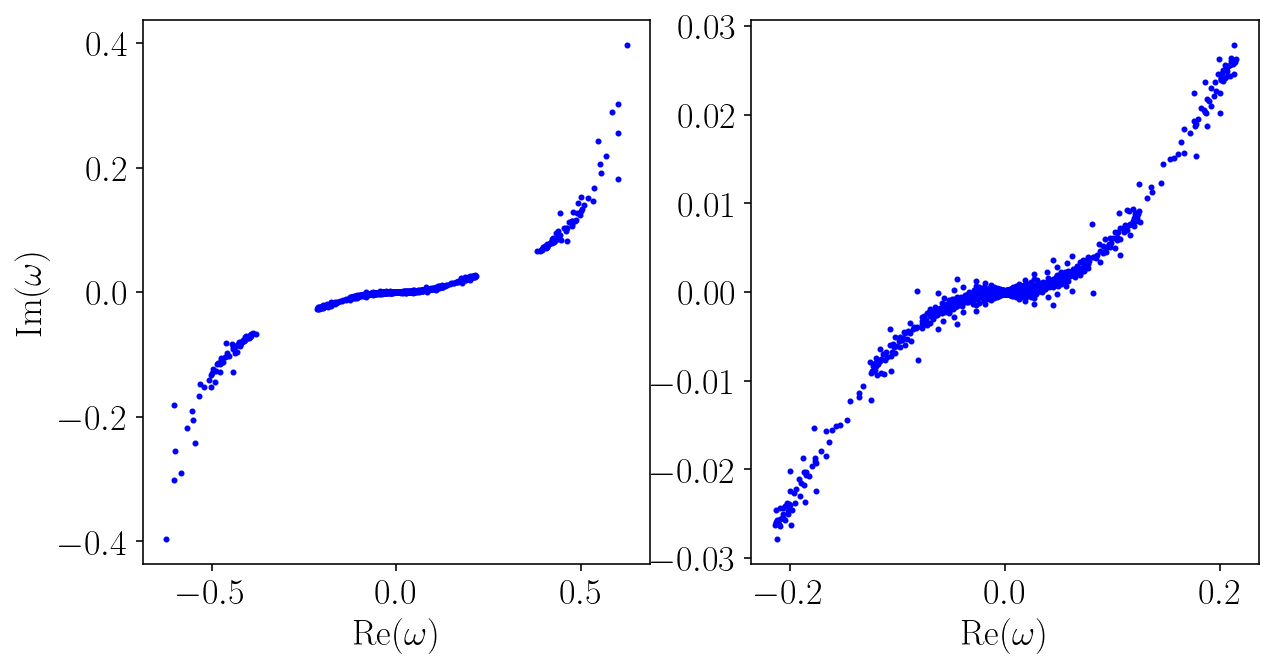

In [252]:
fig,(ax,ax1) = plt.subplots(1,2, figsize=(10,5)) 
ax.plot(ω_eigs.real, ω_eigs.imag, 'bo', markersize=2)
ax1.plot(ω_eigs_trimmed.real, ω_eigs_trimmed.imag, 'bo', markersize=2)
ax.set_ylabel(r'$\textrm{Im}(\omega)$');ax.set_xlabel(r'$\textrm{Re}(\omega)$');ax1.set_xlabel(r'$\textrm{Re}(\omega)$')
plt.show()

In [253]:
ω_eigs_sort = ω_eigs_trimmed[np.argsort(np.abs(ω_eigs_trimmed.real))]
ω_eigs_sort_index = ω_eigs_trimmed_index[np.argsort(np.abs(ω_eigs_trimmed.real))]

In [254]:
ω_eigs_sort_pos = np.flip(ω_eigs_sort[ω_eigs_sort>0])
ω_eigs_sort_pos_index = np.flip(ω_eigs_sort_index[ω_eigs_sort>0])

In [255]:
ω_eigs_sort_pos

array([2.14151098e-01+2.63154204e-02j, 2.13083144e-01+2.59631362e-02j,
       2.13067330e-01+2.61219346e-02j, ...,
       2.47195153e-05-1.37406162e-05j, 2.32215779e-05-1.20495157e-05j,
       2.27372877e-05+1.29389944e-05j])

/var/folders/bg/tg7qc0rx1qxdpz1j_8l_xj440000gq/T/ipykernel_76381/3815978675.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(X,Y,(G['g'].real))


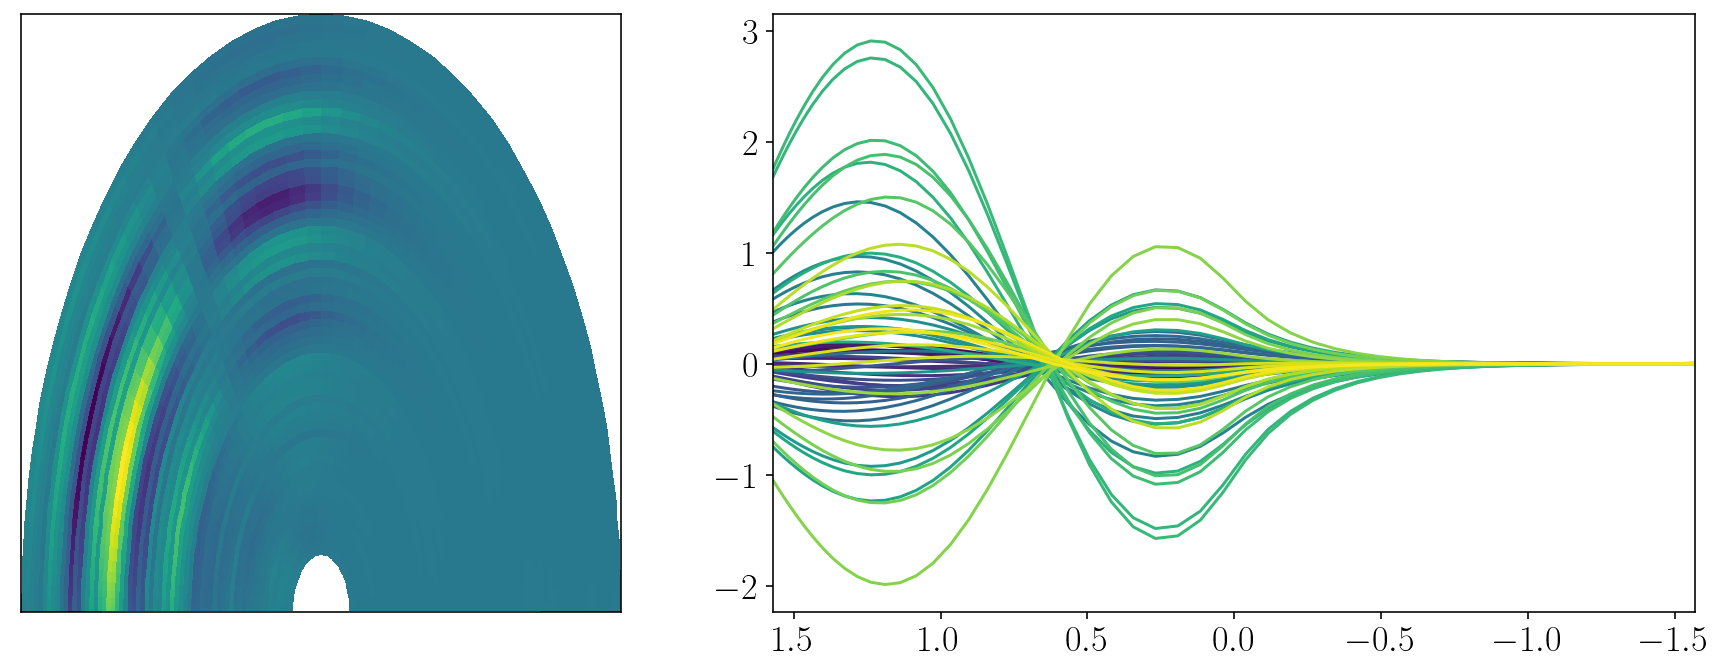

In [276]:
ωx,(ax,ax1) = plt.subplots(1,2, figsize=(15,5.5),gridspec_kw={'width_ratios': [1.3,2]})
i=10
X = R*np.cos(THETA+np.pi/2); Y=R*np.sin(THETA+np.pi/2)
solver.set_state(ω_eigs_sort_pos_index[i], solver.subsystems[0]) 
ax.pcolormesh(X,Y,(G['g'].real))
cmap = mpl.cm.get_cmap('viridis')
for j in range(Nr):
    ax1.plot(θ,np.real(G['g'])[:,j], color=cmap(j/Nr))
    ax1.set_xlim([np.pi/2,-np.pi/2])
ax.set_xticks([]);ax.set_yticks([])
plt.show()

/var/folders/bg/tg7qc0rx1qxdpz1j_8l_xj440000gq/T/ipykernel_76381/2135706333.py:5: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(X,Y,(G['g'].real))


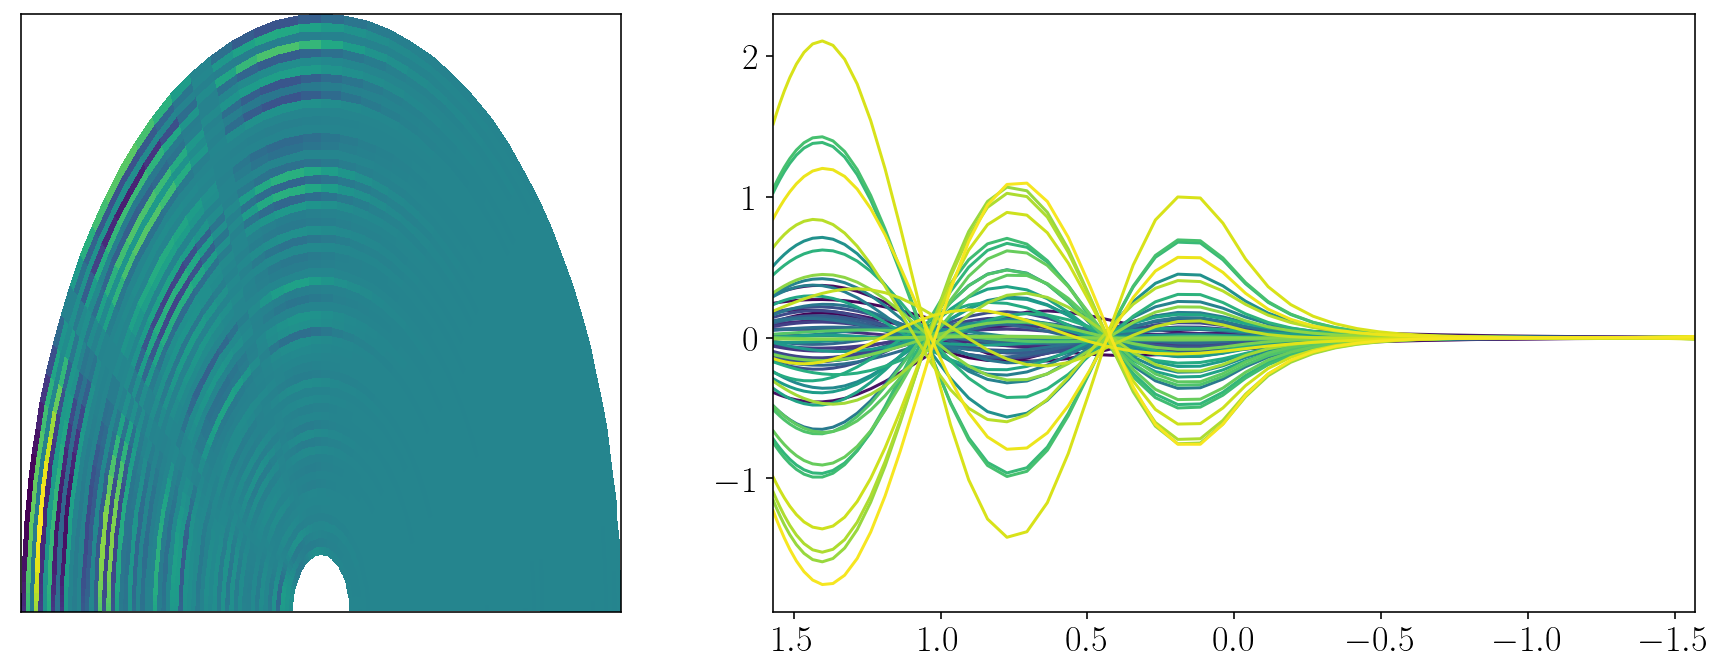

In [275]:
ωx,(ax,ax1) = plt.subplots(1,2, figsize=(15,5.5),gridspec_kw={'width_ratios': [1.3,2]})
i=64
X = R*np.cos(THETA+np.pi/2); Y=R*np.sin(THETA+np.pi/2)
solver.set_state(ω_eigs_sort_pos_index[i], solver.subsystems[0]) 
ax.pcolormesh(X,Y,(G['g'].real))
cmap = mpl.cm.get_cmap('viridis')
for j in range(Nr):
    ax1.plot(θ,np.real(G['g'])[:,j], color=cmap(j/Nr))
    ax1.set_xlim([np.pi/2,-np.pi/2])
ax.set_xticks([]);ax.set_yticks([])
plt.show()